In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
nfft = 2**16

In [3]:
def process(basename, antenna=0, dec=938, fs=6.144, f_lo=8436, spacecraft='JUICE', start_time=None):
    chanx, chany = ['x', 'y']
    x = np.fromfile(f'/mnt/local_data/destevez/JUICE/earth_flyby_2024/'
                    f'{basename}_fft{nfft}_dec{dec}_{antenna}{chanx}{antenna}{chanx}.f32',
                'float32').reshape(-1, nfft)
    y = np.fromfile(f'/mnt/local_data/destevez/JUICE/earth_flyby_2024/'
                    f'{basename}_fft{nfft}_dec{dec}_{antenna}{chany}{antenna}{chany}.f32',
                'float32').reshape(-1, nfft)
    xy = np.fromfile(f'/mnt/local_data/destevez/JUICE/earth_flyby_2024/'
                    f'{basename}_fft{nfft}_dec{dec}_{antenna}{chanx}{antenna}{chany}.c64',
                 'complex64').reshape(-1, nfft)
    chanx, chany = ['X', 'Y']
    
    a = np.average(x)
    b = np.average(y)
    x /= a
    y /= b
    xy /= np.sqrt(a * b)

    print('Power ratio:', a/b)

    date_format = mdates.DateFormatter('%H:%M')
    
    faxis = np.fft.fftshift(np.fft.fftfreq(nfft, 1/fs)) + f_lo
    plt.figure()
    plt.plot(faxis, np.average(x, axis=0), label=f'|{chanx}|^2')
    plt.plot(faxis, np.average(y, axis=0), label=f'|{chany}|^2')
    plt.ylim(0.9, 1.1)
    #plt.plot(faxis, np.average(np.abs(xy), axis=0), label=f'|{chanx}·{chany}|')
    plt.xlabel('Frequency (MHz)')
    plt.title(f'{spacecraft} PSD (linear polarizations)')
    plt.ylabel('PSD (linear)')
    plt.legend()

    faxis = np.fft.fftshift(np.fft.fftfreq(nfft, 1/fs)) + f_lo
    plt.figure()
    plt.plot(faxis, 10*np.log10(np.average(x, axis=0)), label=f'|{chanx}|^2')
    plt.plot(faxis, 10*np.log10(np.average(y, axis=0)), label=f'|{chany}|^2')
    plt.ylim(-0.5, 0.5)
    #plt.plot(faxis, 10*np.log10(np.average(np.abs(xy), axis=0)), label=f'|{chanx}·{chany}|')
    plt.xlabel('Frequency (MHz)')
    plt.title(f'{spacecraft} PSD (linear polarizations)')
    plt.ylabel('PSD (dB)')
    plt.legend()

    tstep = (nfft * dec)/(fs*1e6)
    taxis = tstep * np.arange(x.shape[0])
    if start_time is not None:
        taxis = start_time + (taxis * 1e9) * np.timedelta64(1, 'ns')
    
    stokes_i = 0.5 * (x + y)

    plt.figure()
    plt.plot(faxis, np.average(stokes_i, axis=0), label='Average')
    plt.plot(faxis, np.max(stokes_i, axis=0), label='Maximum')
    plt.ylim(0.9, 1.25)
    plt.xlabel('Frequency (MHz)')
    plt.title(f'{spacecraft} PSD (Stokes I)')
    plt.ylabel('PSD (linear)')
    plt.legend()

    plt.figure()
    plt.plot(faxis, 10*np.log10(np.average(stokes_i, axis=0)), label='Average')
    plt.plot(faxis, 10*np.log10(np.max(stokes_i, axis=0)), label='Maximum')
    plt.ylim(-0.5, 1)
    plt.xlabel('Frequency (MHz)')
    plt.title(f'{spacecraft} PSD (Stokes I)')
    plt.ylabel('PSD (dB)')
    plt.legend()

    fig, axs = plt.subplots(2, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    a = mdates.date2num(start_time) if start_time is not None else 0
    b = (
        mdates.date2num(start_time + (tstep * x.shape[0] * 1e9) * np.timedelta64(1, 'ns'))
        if start_time is not None
        else tstep * x.shape[0])
    axs[0].imshow(10 * np.log10(stokes_i).T[::-1], aspect='auto', vmin=-1, vmax=1,
                  extent=[a, b, f_lo - fs/2, f_lo + fs/2])
    axs[1].plot(taxis, 10 * np.log10(np.average(stokes_i, axis=1)))
    axs[0].set_ylabel('Frequency (MHz)')
    axs[1].set_ylabel('Power (dB)')
    plt.xlabel('Time (s)' if start_time is None
               else f'UTC time ({str(start_time).split("T")[0]})')
    if start_time is not None:
        axs[1].xaxis.set_major_formatter(date_format)
    plt.subplots_adjust(hspace=0.1)
    plt.suptitle(f'{spacecraft} waterfall (Stokes I)', y=0.92)

Power ratio: 0.5288125


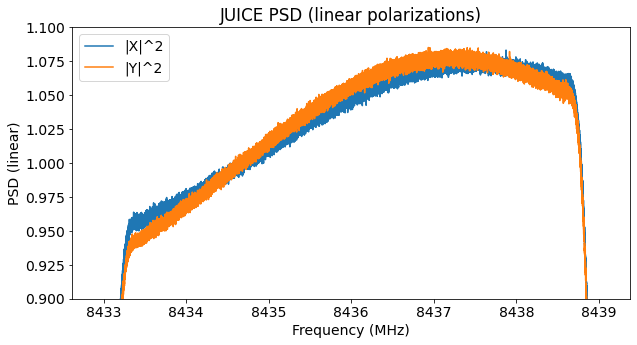

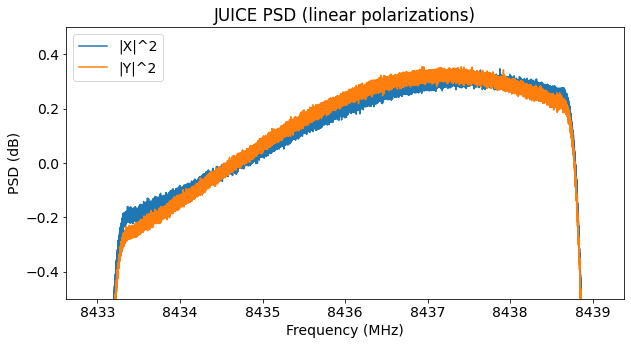

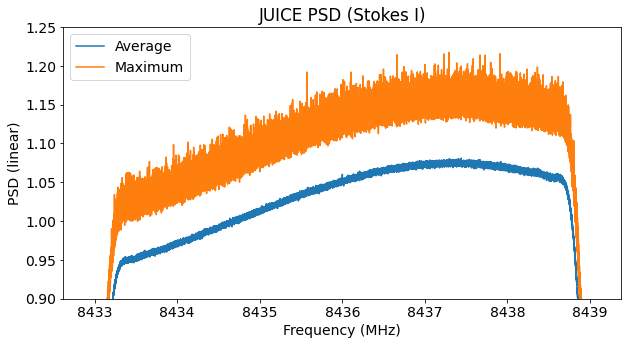

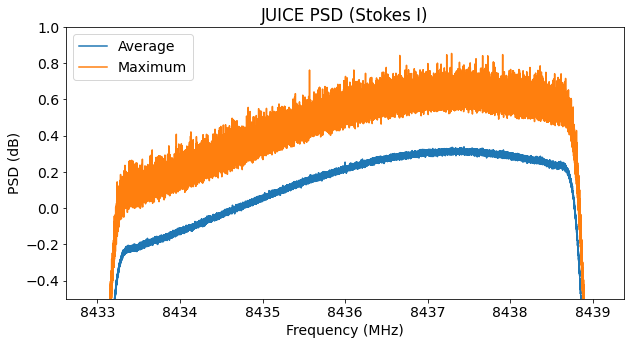

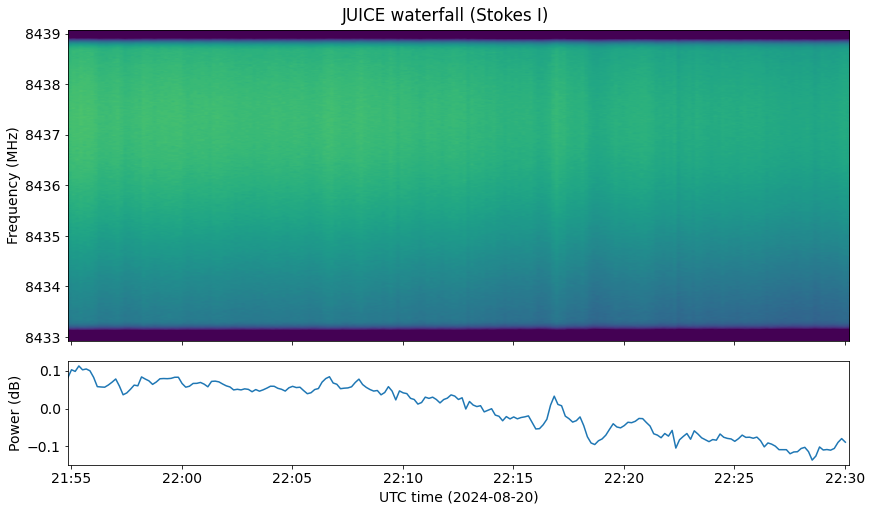

In [4]:
process('JUICE_2024-08-20T21:54:38.436809', start_time=np.datetime64('2024-08-20T21:54:50.137037260'))